In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

In [86]:
# load dataframe from xls
df = pd.read_excel("./default of credit card clients.xls", header=1, index_col=0)
df.head(30)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
7,500000,1,1,2,29,0,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
8,100000,2,2,2,23,0,-1,-1,0,0,...,221,-159,567,380,601,0,581,1687,1542,0
9,140000,2,3,1,28,0,0,2,0,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0


## Transforming the data

### Transforming ages

In [87]:
df['AGE'].describe()

count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

In [88]:
# cutting age into 4 groups
df["AGE_GROUP"] = pd.cut(
    df["AGE"],
    bins=[20, 30, 40, 50, 60, 70, 80],
    labels=["2x", "3x", "4x", "5x", "6x", "7x"],
)
df["AGE_GROUP"].value_counts()


2x    11013
3x    10713
4x     6005
5x     1997
6x      257
7x       15
Name: AGE_GROUP, dtype: int64

<AxesSubplot: >

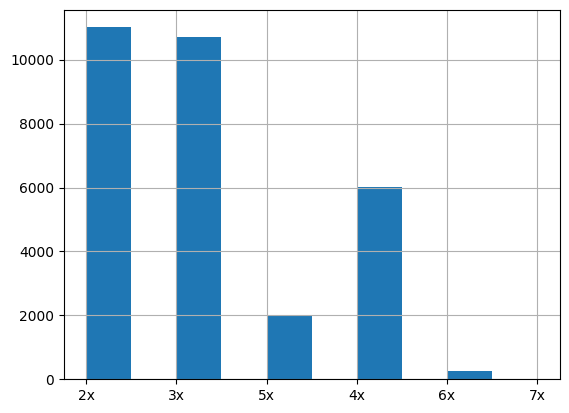

In [89]:
# histogram of age group
df['AGE_GROUP'].hist()

## Data selection

In [90]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'AGE_GROUP'],
      dtype='object')

In [91]:
categorical_features = [
    "SEX",
    "EDUCATION",
    "MARRIAGE",
    "AGE_GROUP",
    "PAY_0",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6",
]

numerical_features = [
    "LIMIT_BAL",
    "BILL_AMT1",
    "BILL_AMT2",
    "BILL_AMT3",
    "BILL_AMT4",
    "BILL_AMT5",
    "BILL_AMT6",
    "PAY_AMT1",
    "PAY_AMT2",
    "PAY_AMT3",
    "PAY_AMT4",
    "PAY_AMT5",
    "PAY_AMT6",
]

target_col = "default payment next month"


In [92]:
X = df[categorical_features + numerical_features]
X_cat = df[categorical_features]
X_num = df[numerical_features]
y = df[target_col]

In [93]:
# scale numerical features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)
X_num_scaled = pd.DataFrame(X_num_scaled, columns=X_num.columns, index=X_num.index)

# label encoding categorical features
label_encoder = LabelEncoder()
label_encoded = X_cat.apply(label_encoder.fit_transform)
X_cat_encoded = pd.DataFrame(label_encoded, columns=X_cat.columns, index=X_cat.index)

assert len(X_num_scaled) == len(X_cat_encoded)

## Feature selection

In [94]:
def calculate_metrics(model, X_test_scaled, Y_test):
    # Get model predictions
    y_predict_r = model.predict(X_test_scaled)

    # Calculate evaluation metrics for assesing performance of the model.
    roc = roc_auc_score(Y_test, y_predict_r)
    acc = accuracy_score(Y_test, y_predict_r)
    prec = precision_score(Y_test, y_predict_r)
    rec = recall_score(Y_test, y_predict_r)
    f1 = f1_score(Y_test, y_predict_r)

    return acc, roc, prec, rec, f1


def train_and_get_metrics(X, Y):
    # Split train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, stratify=Y, random_state=42
    )

    # define the model to use
    model = RandomForestClassifier(criterion="entropy", random_state=123)

    # Train the model
    model.fit(X_train, Y_train)

    # Make predictions on test dataset and calculate metrics.
    roc, acc, prec, rec, f1 = calculate_metrics(model, X_test, Y_test)

    return acc, roc, prec, rec, f1


def evaluate_model_on_features(X, Y):
    # Train the model, predict values and get metrics
    acc, roc, prec, rec, f1 = train_and_get_metrics(X, Y)

    # Construct a dataframe to display metrics.
    display_df = pd.DataFrame(
        [[acc, roc, prec, rec, f1, X.shape[1]]],
        columns=["Accuracy", "ROC", "Precision", "Recall", "F1 Score", "Feature Count"],
    )

    return display_df


In [95]:
X_original = pd.concat([X_cat_encoded, X_num_scaled], axis=1)
all_features_eval_df = evaluate_model_on_features(X_original, y)
all_features_eval_df.index = ['All features']

# Initialize results dataframe
feature_extraction_eval_table = all_features_eval_df.copy()

# Check the metrics
feature_extraction_eval_table.head()

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.651114,0.8125,0.633245,0.361718,0.460432,23


### ANOVA F-value For numerical feature selection

One way ANOVA test can be used to find relationship between numeric and a categorical variable

Here,
Null hypothesis H0 : two groups have same variance.
Alternate hypothesis H1: aleast one of the group have different variance

ie, if two groups have same variance it indicates that those feature is not important. We can drop them on feature selection. otherwise we wont drop the feature.

The basic idea is that we will find

    Fscore = (variance_between groups/ variance_within groups)

and compare it with critical value obtained from F value table to accept or reject null hypothesis.

Sklearn provides method called f_classif to do Anova F test and we can use it with Select K best for faster results. We dont have to do seperate for each input feature. If the value ‘variance_between / variance_within’ is less than the critical value (evaluated using log table). The library returns score and p value, for p<0.05 we mean that the confidence>95% for them to belong to the same population and hence are co-related. We select top k co-related features according to the score returned by Anova.

In [96]:
fvalue_selector = SelectKBest(f_classif, k=10)
fvalue_selector.fit(X_num_scaled, y)

df_score = pd.DataFrame(fvalue_selector.pvalues_,columns=['p_values'])
df_score['score'] = fvalue_selector.scores_
df_score['columns'] = X_num_scaled.columns

df_score.sort_values(by='score', ascending=False, inplace=True)
df_score

,p_values,score,columns
0,1.302244e-157,724.068539,LIMIT_BAL
7,1.146488e-36,160.403810,PAY_AMT1
8,3.166657e-24,103.291524,PAY_AMT2
10,6.830942e-23,97.188000,PAY_AMT4
9,1.841770e-22,95.218011,PAY_AMT3
11,1.241345e-21,91.429801,PAY_AMT5
12,3.033589e-20,85.089045,PAY_AMT6
1,6.673295e-04,11.580532,BILL_AMT1
2,1.395736e-02,6.044238,BILL_AMT2
3,1.476998e-02,5.944388,BILL_AMT3


In [97]:
# get list of features with p-value < 0.05
selected_num_features = df_score[df_score['p_values'] < 0.05]['columns'].tolist()
selected_num_features

['LIMIT_BAL',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT4',
 'PAY_AMT3',
 'PAY_AMT5',
 'PAY_AMT6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3']

In [98]:
X_num_scaled_new = X_num_scaled[selected_num_features].copy()
X_new = pd.concat([X_cat_encoded, X_num_scaled_new], axis=1)

strong_num_features_eval_df = evaluate_model_on_features(X_new, y)
strong_num_features_eval_df.index = ["Selected num. features"]

feature_extraction_eval_table = feature_extraction_eval_table.append(
    strong_num_features_eval_df
)
feature_extraction_eval_table.head()

C:\Users\trmin\AppData\Local\Temp\ipykernel_26620\1333704280.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_extraction_eval_table = feature_extraction_eval_table.append(


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.651114,0.8125,0.633245,0.361718,0.460432,23
Selected num. features,0.652091,0.8115,0.626289,0.366240,0.462197,20


### Chi-Square test for categorical feature selection

In [99]:
chi_selector = SelectKBest(score_func=chi2, k=5)
fit = chi_selector.fit(X_cat_encoded, y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_cat_encoded.columns)

f_scores = pd.concat([df_columns, df_scores], axis=1)
f_scores.columns = ['Feature', 'Score']
f_scores

,Feature,Score
0,SEX,18.983326
1,EDUCATION,7.931259
2,MARRIAGE,3.120010
3,AGE_GROUP,7.824658
4,PAY_0,2015.175489
5,PAY_2,1600.272996
6,PAY_3,1296.927064
7,PAY_4,1081.317089
8,PAY_5,421.891456
9,PAY_6,367.152234


In [100]:
selected_categorical_features = X_cat_encoded.columns[
    chi_selector.get_support()
].tolist()
selected_categorical_features


['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5']

In [101]:
X_cat_scaled_new = X_cat_encoded[selected_categorical_features].copy()
X_new = pd.concat([X_cat_scaled_new, X_num_scaled], axis=1)

strong_cat_features_eval_df = evaluate_model_on_features(X_new, y)
strong_cat_features_eval_df.index = ["Selected cat. features"]

feature_extraction_eval_table = feature_extraction_eval_table.append(
    strong_cat_features_eval_df
)
feature_extraction_eval_table.head()


C:\Users\trmin\AppData\Local\Temp\ipykernel_26620\2985562160.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_extraction_eval_table = feature_extraction_eval_table.append(


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.651114,0.8125,0.633245,0.361718,0.460432,23
Selected num. features,0.652091,0.8115,0.626289,0.366240,0.462197,20
Selected cat. features,0.644871,0.8095,0.623656,0.349661,0.448093,18


### Combining both numerical and categorical feature selection

In [102]:
X_new = pd.concat([X_cat_scaled_new, X_num_scaled_new], axis=1)

strong_features_eval_df = evaluate_model_on_features(X_new, y)
strong_features_eval_df.index = ["All selected features"]

feature_extraction_eval_table = feature_extraction_eval_table.append(
    strong_features_eval_df
)
feature_extraction_eval_table.head()


C:\Users\trmin\AppData\Local\Temp\ipykernel_26620\111972683.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_extraction_eval_table = feature_extraction_eval_table.append(


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.651114,0.812500,0.633245,0.361718,0.460432,23
Selected num. features,0.652091,0.811500,0.626289,0.366240,0.462197,20
Selected cat. features,0.644871,0.809500,0.623656,0.349661,0.448093,18
All selected features,0.646974,0.809833,0.623016,0.354936,0.452232,15


### Using tree-based model to extract important features

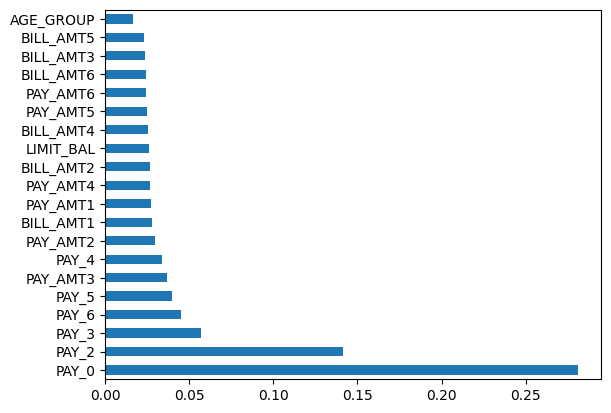

<Figure size 800x600 with 0 Axes>

In [103]:
import xgboost
import matplotlib.pyplot as plt

model = xgboost.XGBRegressor(seed=42)
X_train = pd.concat([X_cat_encoded, X_num_scaled], axis=1, ignore_index=True)
model.fit(X_train, y)

# plot the graph of feature importances for better visualization 
feat_imp = pd.Series(model.feature_importances_, index=X.columns)
feat_imp.nlargest(20).plot(kind='barh')

plt.figure(figsize=(8,6))
plt.show()

In [104]:
selected_features_from_tree = feat_imp.nlargest(20).index.tolist()
selected_features_from_tree

['PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_6',
 'PAY_5',
 'PAY_AMT3',
 'PAY_4',
 'PAY_AMT2',
 'BILL_AMT1',
 'PAY_AMT1',
 'PAY_AMT4',
 'BILL_AMT2',
 'LIMIT_BAL',
 'BILL_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'BILL_AMT6',
 'BILL_AMT3',
 'BILL_AMT5',
 'AGE_GROUP']

In [105]:
X_tree_new = X[feat_imp.nlargest(15).index.tolist()].copy()

tree_features_eval_df = evaluate_model_on_features(X_tree_new, y)
tree_features_eval_df.index = ["Tree selected features"]

feature_extraction_eval_table = feature_extraction_eval_table.append(
    tree_features_eval_df
)
feature_extraction_eval_table.head()


C:\Users\trmin\AppData\Local\Temp\ipykernel_26620\2879862455.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_extraction_eval_table = feature_extraction_eval_table.append(


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.651114,0.812500,0.633245,0.361718,0.460432,23
Selected num. features,0.652091,0.811500,0.626289,0.366240,0.462197,20
Selected cat. features,0.644871,0.809500,0.623656,0.349661,0.448093,18
All selected features,0.646974,0.809833,0.623016,0.354936,0.452232,15
Tree selected features,0.651281,0.811500,0.627273,0.363979,0.460658,15


### Correlation matrix between limit balance and bill amount

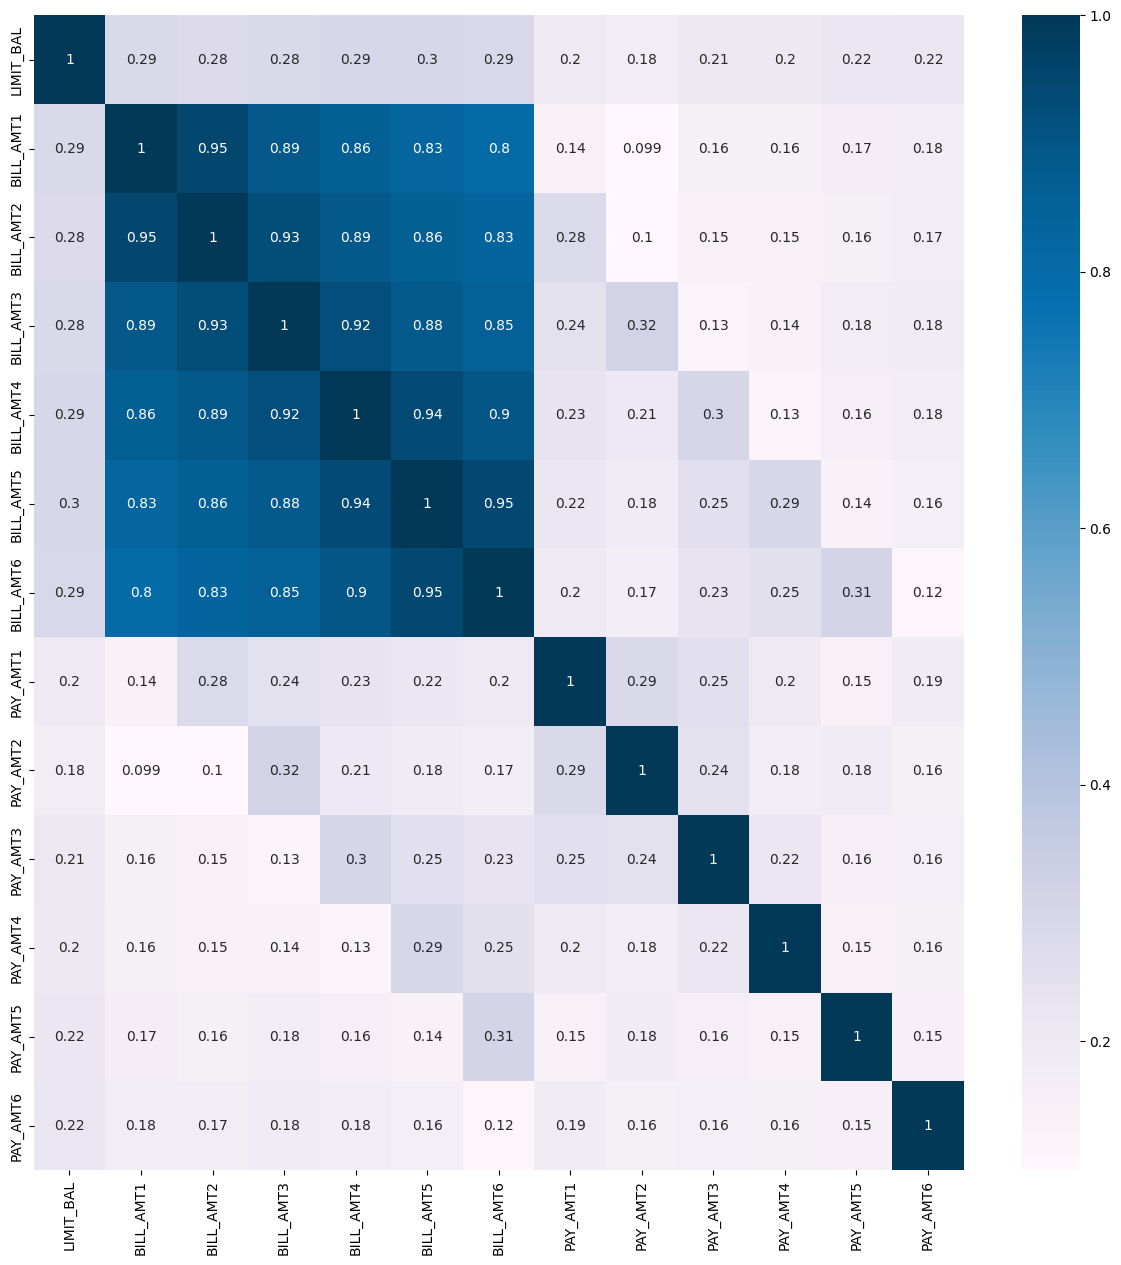

In [110]:
X_cor = X_num_scaled.copy()

# Set figure size
plt.figure(figsize=(15,15))

# Calculate correlation matrix
cor = X_cor.corr() 

# Plot the correlation matrix
sns.heatmap(cor, annot=True, cmap=plt.cm.PuBu)
plt.show()

### Result

In [107]:
selected_features1 = selected_num_features + selected_categorical_features
print(selected_features1)

['LIMIT_BAL', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT5', 'PAY_AMT6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5']


In [108]:
selected_features2 = selected_features_from_tree
print(selected_features2)

['PAY_0', 'PAY_2', 'PAY_3', 'PAY_6', 'PAY_5', 'PAY_AMT3', 'PAY_4', 'PAY_AMT2', 'BILL_AMT1', 'PAY_AMT1', 'PAY_AMT4', 'BILL_AMT2', 'LIMIT_BAL', 'BILL_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'BILL_AMT6', 'BILL_AMT3', 'BILL_AMT5', 'AGE_GROUP']


In [109]:
tree_features = set(feat_imp.nlargest(15).index.tolist())
for feature in selected_features1:
    if feature not in tree_features:
        print(f'{feature} is not considered by tree based models')
        
for feature in tree_features:
    if feature not in selected_features1:
        print(f'{feature} is not considered by statistical models')

PAY_AMT6 is not considered by tree based models
BILL_AMT3 is not considered by tree based models
PAY_6 is not considered by statistical models
BILL_AMT4 is not considered by statistical models
